In [27]:
import re
from typing import List, Union, Tuple
from nltk.corpus import stopwords as stpwrds
from sklearn.model_selection import train_test_split
import time
from os.path import isfile
import numpy as np
# Webscraping
from bs4 import BeautifulSoup
from requests import get
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import nltk.sentiment


import os

import matplotlib.pyplot as plt
import json
from typing import Dict, List, Optional, Union, cast
import requests
import prepare as p
from nltk.tokenize.toktok import ToktokTokenizer

from scipy import stats
import acquire as w

In [36]:
df = w.get_michelin_pages()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6780 entries, 0 to 6779
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     6780 non-null   object 
 1   address                  6780 non-null   object 
 2   location                 6780 non-null   object 
 3   price                    6726 non-null   object 
 4   cuisine                  6780 non-null   object 
 5   longitude                6780 non-null   float64
 6   latitude                 6780 non-null   float64
 7   phone_number             6649 non-null   float64
 8   url                      6780 non-null   object 
 9   website_url              5542 non-null   object 
 10  award                    6780 non-null   object 
 11  facilities_and_services  6732 non-null   object 
 12  data                     6780 non-null   object 
dtypes: float64(3), object(10)
memory usage: 688.7+ KB


In [41]:
train, validate, test = p.prepare_michelin(df)

In [48]:
# create sentimate dataframe for 
sentiment_df = train[['award','lemmatized']]

In [49]:
sentiment_df

,award,lemmatized
6345,bib gourmand,straight picture book beautiful inn stand edge...
6427,bib gourmand,steeped tradition run great commitment lovely ...
5217,bib gourmand,1993 dumpling shop began life street stall loc...
3858,bib gourmand,unpretentious friendly informal whose aim prov...
124,3 michelin stars,iconic celebrated 25year anniversary 2021 intr...
...,...,...
4492,bib gourmand,trattoria named famous cibreo typical stew flo...
2145,1 michelin star,imagine austrian prince princess white gold ro...
913,1 michelin star,youre looking somewhere eat solid reputation l...
4738,bib gourmand,sapporostyle lamb barbecue name game kyoyang s...


In [52]:
def get_sentiment(sentiment_df):
    '''Function calculates sentiment score and creates dataframe of scores'''
    # reindex dataframe
    sentiment_df.reset_index(drop =True, inplace=True)
    #create sentiment object
    sia = nltk.sentiment.SentimentIntensityAnalyzer()
    
    # create row id column
    sentiment_df["row_id"] =sentiment_df.index +1
    
    # create subsets
    df_subset = sentiment_df[['row_id', 'lemmatized']].copy()
    
    # set up empty dataframe for staging output
    df1=pd.DataFrame()
    df1['row_id']=['99999999999']
    df1['sentiment_type']='NA999NA'
    df1['sentiment_score']=0
    
    # run loop to calculate and save sentiment values
    t_df = df1
    for index,row in df_subset.iterrows():
        scores = sia.polarity_scores(row[1])
        for key, value in scores.items():
            temp = [key,value,row[0]]
            df1['row_id']=row[0]
            df1['sentiment_type']=key
            df1['sentiment_score']=value
            t_df=t_df.append(df1)
    #remove dummy row with row_id = 99999999999
    t_df_cleaned = t_df[t_df.row_id != '99999999999']
    #remove duplicates if any exist
    t_df_cleaned = t_df_cleaned.drop_duplicates()
    # only keep rows where sentiment_type = compound
    t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
    
    df_output = pd.merge(sentiment_df, t_df_cleaned, on='row_id', how='inner')
    
    #generate mean of sentiment_score by period
  
    dfg = df_output.groupby(['award'])['sentiment_score'].mean()
    #create a bar plot
    dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='',fontsize =20,color=['#beaed4','#f0027f','#7fc97f','#fdc086'])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=22)
    plt.show()
   
    return df_output;

/var/folders/hb/h75yrttj2jx98ftlw744r4hm0000gn/T/ipykernel_45712/797819918.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["row_id"] =sentiment_df.index +1
/var/folders/hb/h75yrttj2jx98ftlw744r4hm0000gn/T/ipykernel_45712/797819918.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
/var/folders/hb/h75yrttj2jx98ftlw744r4hm0000gn/T/ipykernel_45712/797819918.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
/var/folders/hb/h75yrttj2jx98ftlw744r4hm0000gn/T/ipykernel_45712/797819918.py:29: FutureWarning: The fram

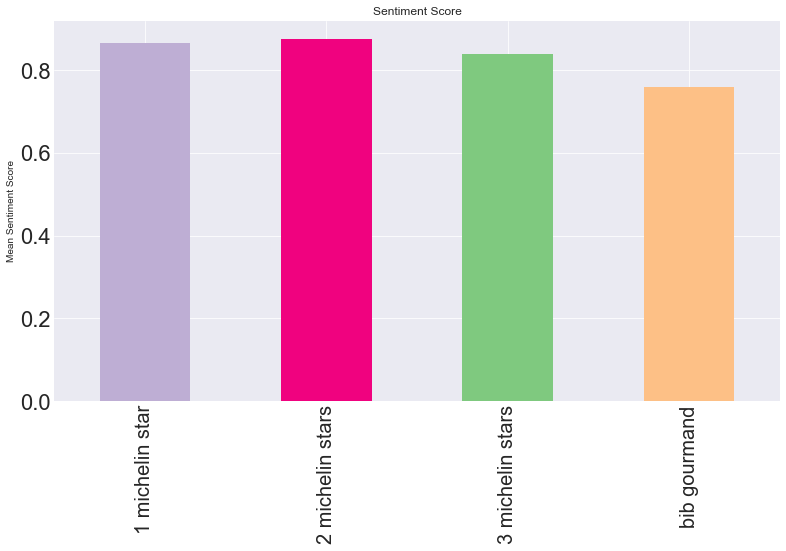

In [53]:
sentiment2_df = get_sentiment(sentiment_df)

In [57]:
sentiment2_df.sentiment_score.sort_values(ascending=False)

29      0.9962
1502    0.9943
452     0.9941
3044    0.9934
776     0.9931
         ...  
1020   -0.6776
1300   -0.6908
1730   -0.7003
921    -0.7619
8      -0.7650
Name: sentiment_score, Length: 3793, dtype: float64